# The effect of PCA components in accuracy of image models and model interpretability based on GradientBoostingClassifier

## 1. Introduction to model interpretability-LIME:  

### What is LIME?  
- LIME (Local Interpretable Model Explainer) is a tool that allows you to explain a decision made by your classification model. This can either be a decision tree, random forest or even a neural network. 
- For example when you have a neural network that predicts a label for an image you can explain its functionality by LIME.

### Why LIME?
'Features that are globally important may not be important in the local context, and vice versa. While global fidelity would imply local fidelity, identifying globally faithful explanations that are interpretable remains a challenge for complex models.'  
                    — Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin'
- __We will figure out:__
    - Which segments will represent the top features explaining the classification of the image as containing a specific object (like tennis/basketball etc.)?  
    
### How LIME works?
- LIME produces explanations in the form of image segments. 
- We create a new explainer for our image classifier. Then we let it explain the classification for a specific image. This produces an explanation object that we can visualize.

### Pros of LIME:
- LIME treats the classifying model as a “black box”, and thus does not depend at all on the architecture of the original classifier (this is LIME’s Model-Agnostic attribute). This is a really cool feature that enables to get an “explanation” for any classifier.  
- The current LIME library was designed to work with:
    - Tensorflow;
    - Keras;
    - integrate it with PyTorch – namely converting some variables to Tensors

### Challenges of LIME:
- Computationally heavy: The original LIME tutorial cites 7.65 minutes for generating an explanation for a given image.  
- “bottle neck” of the process: was generating and classifying 1000 variants of the original image.  
- it is quite hard to find a non-qualitative measure for how “good” an explanation is.
<img src = 'Image/LIME_cons.png'>

### Further action:
- ??? How could we conduct multiple explanations for classifying the same image?
     - Thought: It would probably also be a good idea to cache the image segmentation outcome altogether.

## 2. Face emotion classification and interpretation based on shared error prediction:
### Datasource: https://cs.nyu.edu/~roweis/data.html  
- In the dataset, there are images of 40 people with 10 different poses e.g. smiling and angry faces etc. Therefore, there are total 400 samples.  
- The images size is (64, 64), which is stored as features of size 4096

### Goal:  
- For optimizing XGM model by exploring interpretability of important features.
- For the trade-off of accuracy VS wall time , find out the best number of componenents of PCA with quantitative measures and human intervention.
- Explore how the classification/prediction will be affected by XGB models with different PCA components.  
- Figure out by interpretability: What the different features between these images which were always predicted wrongly by training all models with different number of PCA componenents.  

### Structure:
<img src='Image/Archi.png'>

### 2.0 Some Variable for storing results:

In [619]:
list_pca_wrong_prediction_count = [] # Store the tuples: number of wrong predicted results with different PCA.
list_pca_number_wrongPredictionLocation = [] # Store the tuples: (number of PCA components, wrong Predictions locations).
list_pca_wrongPrediction_intersection = [] # Store the intersection of results different number of component in PCA.
list_pipeline_RF = [] #Store the pipeline with different number of components into list for iteration.

### 2.1 Import lib:

In [765]:
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images
from skimage.util import montage # to make a nice montage of the images
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA # contains a randomized method to approximate the first $N$ principal components much more quickly than the standard PCA estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000)

In [621]:
%load_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

from lime.wrappers.scikit_image import SegmentationAlgorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2.2 Import face dataset:

In [622]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [623]:
faces.data.shape

(400, 4096)

In [624]:
len(faces.images) # 400 images

400

In [625]:
faces.data

array([[0.30991736, 0.3677686 , 0.41735536, ..., 0.15289256, 0.16115703,
        0.1570248 ],
       [0.45454547, 0.47107437, 0.5123967 , ..., 0.15289256, 0.15289256,
        0.15289256],
       [0.3181818 , 0.40082645, 0.49173555, ..., 0.14049587, 0.14876033,
        0.15289256],
       ...,
       [0.5       , 0.53305787, 0.607438  , ..., 0.17768595, 0.14876033,
        0.19008264],
       [0.21487603, 0.21900827, 0.21900827, ..., 0.57438016, 0.59090906,
        0.60330576],
       [0.5165289 , 0.46280992, 0.28099173, ..., 0.35950413, 0.3553719 ,
        0.38429752]], dtype=float32)

__Note__:  
-  If (1797, 64) is the shape, means they are 64-dimensional.   
- In this case, should be 4096(64*64) dimensional for each image.

### 2.3 Reshape X_vec and Get Target y_vec:

- Next, will make each image color so lime_image works correctly:
 - __X_vec:__
    - 1. Reshape the every face in dataset to be new-sized: (-1, 64, 64)
    - 2. Stack the new-sized matrix along with vertical axis- by numpy.stack(, axis=0)
    - 3. Color the gray image for LIME explanation correctly.
 - __y_vec:__
    - 1. target of face: Labels associated to each face image. Those labels are ranging from 0-39 and correspond to the Subject IDs.

In [626]:
X_vec = np.stack([gray2rgb(img) for img in faces.data.reshape((-1,64,64))],axis=0)
y_vec = faces.target.astype(np.uint8)

In [627]:
print(X_vec.shape)
print(X_vec[:,:,:,0].shape)

(400, 64, 64, 3)
(400, 64, 64)


In [628]:
y_vec

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

- Note:  
'-1': what it does is the notation for unknown dimension, meaning: let numpy fill the missing dimension with the correct value so my array remain with the same number of items.  
    - e.g.: x = x.reshape((10, 1000))=>x = x.reshape((10, -1)) or x = x.reshape((-1, 1000))   

### 2.4 Plot images and define plot function:

(-0.5, 1279.5, 1279.5, -0.5)

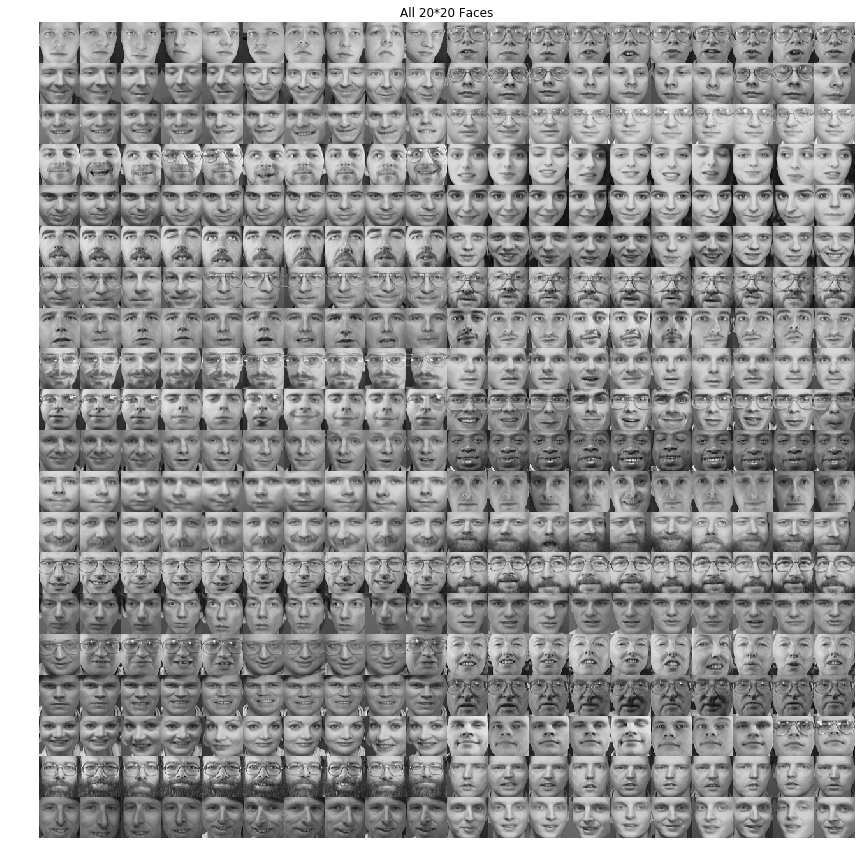

In [629]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1, figsize = (15,15))
ax1.imshow(montage(X_vec[:,:,:,0]),cmap='gray') 
# Note: must by X_vec[:,:,:,0] not X_vec[:,:,:,3]
# Otherwise: index 3 will be out of bounds for axis 3 with size 3

ax1.set_title('All 20*20 Faces')
ax1.axis('off')

In [630]:
# function for plotting images:
# This function is for the purpose of plotting with specific images num, by rows*cols specified.
def plot_images(images, title, total_images, rows):
    fig= plt.figure(figsize = (12,12)) # create a new figure window
    
    fig.suptitle(title)
    for i in range(total_images): # display specific images (eg.:20)
        # subplot : e.g.:4 rows and 5 columns
        img_grid = fig.add_subplot(rows, int(round(total_images/rows)), i+1)
        
        # plot features as image
        img_grid.imshow(images[i], cmap='gray')

In [631]:
#plot_images(faces.images, 'test', 24, 6)

__Note__:  
   - Montage: https://scikit-image.org/docs/0.7.0/api/skimage.util.montage.html

### 2.4 Split the data:

In [632]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.70)

c:\python37\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 3. Setup a Pipeline for processing the images

In [633]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

In [634]:
class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)

### 3.1 Turn Gray for each image:

In [635]:
step_turnGray = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])

### 3.2 Flatten the image back to 1d vectors:

- image.ravel(): Return a contiguous flattened array (A 1-D array, containing the elements of the input, is returned.)

In [636]:
step_flatten = PipeStep(lambda img_list:[img.ravel() for img in img_list])

### 3.3 Choosing the number of components for PCA:    
- __PCA(principal component analysis)__:  
    - __What__:  
    one of the algorithms for dimensionality reduction: For dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.  
    - __Why__:  
    - This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.
    - __How__:  
        - In PCA, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.
    The projection of each data point onto the principal axes are the "principal components" of the data: The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.  
        - A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.  
        - The fit learns some quantities from the data, most importantly the "components" and "explained variance":  
            - <font color='red'>"__components__"</font> to define the <font color='red'>direction</font> of the vector.  
            - <font color='red'>"__explained variance__"</font> to define the <font color='red'>squared-length</font> of the vector.
            - These vectors represent the principal axes of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data (more precisely, it is a measure of the variance of the data when projected onto that axis.)
    - __Copmare with pixel basis dimension reduction__:  
        - Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus some components.

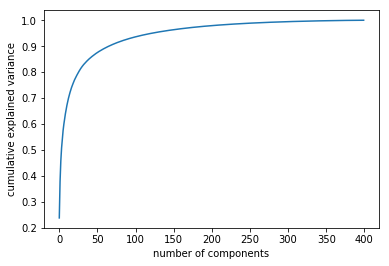

In [637]:
pca = PCA().fit(faces.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

__Note__:  
    This curve quantifies how much of the total, 400-dimensional variance is contained within the first N components.  
    For example, we see that with the digits the first 40 components contain approximately 75% of the variance, while you need around 300 components to describe close to 100% of the variance.

Here we see that our 25(perhaps)-dimensional projection loses a lot of information (as measured by the explained variance) and that we need about 100 components to retain 90% of the variance.  

- Therefore, in next sections will compare with 4 'number of components' for further fit and interpretability to figure out how the 'number of component' affects the result and interpretability:
    - __Part 1__: 'number of component' == 5: 0.6;  
    - __Part 2__: 'number of component' == 10 : 0.7;  
    - __Part 3__: 'number of component' == 50 : 0.85; 
    - __Part 4__: 'number of component' == 100 : 0.9; 
    - __Part 5__: 'number of component' == 250 : 0.95; 
    - __Part 6__: 'number of component' == 280 : 0.99; 

## 4. Make a pipeline to include all steps:

__Pipelines__:  
- It is a way to streamline a lot of the routine processes, encapsulating little pieces of logic into one function call, which makes it easier to actually do modeling instead just writing a bunch of code.   
-  Pipelines are set up with the fit/transform/predict functionality.  
- It provides a way to take code, fit it to the training data, apply it to the test data without having to copy and paste everything.

<font color = 'red'> __Part 1: 'number of component' == 5: 0.6__</font>

In [638]:
%%time
pipeline_RF_5 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(n_components=5)), # project from 4096 to 5 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

Wall time: 996 µs


In [639]:
%%time
pipeline_RF_5.fit(X_train, y_train)

Wall time: 2.19 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x000001DD96EE2D30>), ('Flatten images', <__main__.PipeStep object at 0x000001DD96EFD2B0>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [640]:
list_pipeline_RF.append(tuple(('pipeline_RF_5', pipeline_RF_5)))

<font color = 'red'> __Part 2: 'number of component' == 10: 0.7__</font>

In [641]:
pipeline_RF_10 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(10)), # # project from 4096 to 10 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [642]:
%%time
pipeline_RF_10.fit(X_train, y_train)

Wall time: 2.47 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x000001DD96EE2D30>), ('Flatten images', <__main__.PipeStep object at 0x000001DD96EFD2B0>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0....    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [643]:
list_pipeline_RF.append(tuple(('pipeline_RF_10',pipeline_RF_10)))

<font color = 'red'> __Part 3: 'number of component' == 50: 0.85__</font>

In [644]:
pipeline_RF_50 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(50)), # # project from 4096 to 50 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [645]:
%%time
pipeline_RF_50.fit(X_train, y_train)

Wall time: 3.57 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x000001DD96EE2D30>), ('Flatten images', <__main__.PipeStep object at 0x000001DD96EFD2B0>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0....    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [646]:
list_pipeline_RF.append(tuple(('pipeline_RF_50',pipeline_RF_50)))

<font color = 'red'> __Part 4: 'number of component' == 100: 0.90__</font>

In [647]:
pipeline_RF_100 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(100)), # # project from 4096 to 100 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [648]:
%%time
pipeline_RF_100.fit(X_train, y_train)

Wall time: 4.88 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x000001DD96EE2D30>), ('Flatten images', <__main__.PipeStep object at 0x000001DD96EFD2B0>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [649]:
list_pipeline_RF.append(tuple(('pipeline_RF_100',pipeline_RF_100)))

<font color = 'red'> __Part 5: 'number of component' == 250: 0.95__</font>

In [650]:
pipeline_RF_250 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(250)), # # project from 4096 to 250 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [651]:
%%time
pipeline_RF_250.fit(X_train, y_train)

Wall time: 10.1 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x000001DD96EE2D30>), ('Flatten images', <__main__.PipeStep object at 0x000001DD96EFD2B0>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=250, random_state=None,
  svd_solver='auto', tol=0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [652]:
list_pipeline_RF.append(tuple(('pipeline_RF_250',pipeline_RF_250)))

<font color = 'red'> __Part 6: 'number of component' == 280: 0.99__</font>  
- min(n_samples, n_features)=280

In [653]:
pipeline_RF_280 = Pipeline([('Turn Gray',step_turnGray),
                        ('Flatten images', step_flatten),
                        ('Normalize', Normalizer()),
                        ('PCA', PCA(280)), # # project from 4096 to 280 dimensions
                        ('XGBoost_Model', GradientBoostingClassifier())])

In [654]:
%%time
pipeline_RF_280.fit(X_train, y_train)

Wall time: 10 s


Pipeline(memory=None,
     steps=[('Turn Gray', <__main__.PipeStep object at 0x000001DD96EE2D30>), ('Flatten images', <__main__.PipeStep object at 0x000001DD96EFD2B0>), ('Normalize', Normalizer(copy=True, norm='l2')), ('PCA', PCA(copy=True, iterated_power='auto', n_components=280, random_state=None,
  svd_solver='auto', tol=0...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

In [655]:
list_pipeline_RF.append(tuple(('pipeline_RF_280',pipeline_RF_280)))

__Note__:  
  - __Normalization:__   
    - Numbers closer together (in the sense of continuous space with a linear scale) are also more likely to produce a smoother optimization path.
    - Steps:  
       - 1. Computing a mean and standard deviation of the images
       - 2. (from all images) we subtract the mean and divide by the standard deviation.  
    - Tips:  
       - Optimization must come from the training dataset itself, and must not be computed over the entire dataset including the validation/test datasets. This is because that information should not be passed to the model in any way - it is kind of cheating.

- __PCA(Principal Component Analysis)__:  
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
    - PCA is very useful for reducing many dimensions into a smaller set of dimensions, as humans can not visualize data on more than 3 dimensions it is usually helpful to reduce multidimensional datasets into 2 or 3 dimensions and graph them in order to get a better understanding of the data.  
    - In this case, we reduced from 10304 dimension to 25-dimensional: we have found the optimal stretch and rotation in 10304-dimensional space that allows us to see the layout of the digits in 25 dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.  
    i.e.: 
    __x=[x1,x2,x3⋯x10304] to image(x)=x1⋅(pixel 1)+x2⋅(pixel 2)+x3⋅(pixel 3)⋯x10304⋅(pixel 10304)__

- __Pipeline functions:__
    - fit() to fit to training data;
    - transform() to apply it to training data;
    - fit_transform() to do both.

## 5. Scoring the Models:

In [656]:
from sklearn.metrics import classification_report

In [657]:
def wrong_detected(pca_pipe, pca_num, rangeOfpredictedImage):
    list_wrong = []

    for i in range (rangeOfpredictedImage):
        # if images are not same then print location of images
        if y_test[i] != pca_pipe[i]:
            list_wrong.append(i)
            
    list_pca_wrong_prediction_count.append((pca_num,len(list_wrong))) #Store the number of wrong prediction into list.
    list_pca_number_wrongPredictionLocation.append((pca_num,list_wrong)) 
    
    print('Wrongly detected image-locations:', list_wrong)
    print('Total:', len(list_wrong))

In [658]:
def compare_test_predicted(images, firstNImages, rows, test_targets, prediction_test_targets):
    # store test images in list
    faces_test = []
    for i in test_targets:
        faces_test.append(images[i])

    # store predicted images in list
    faces_predict = []
    for i in prediction_test_targets:
        faces_predict.append(images[i])

    # plot the first 20 images from the list
    plot_images(faces_test, 'faces_test', firstNImages, rows) #plot_images(faces.images, 'test', 24, 6)
    plot_images(faces_predict, 'faces_predict', firstNImages, rows)  # plot_images(faces.images, 'test', 24, 6)
    plt.show()
    
    return faces_test

<font color = 'red'> __Part 1: 'number of component' == 5: 0.6__</font>

#### 5.1 Predict based on pipeline, and evaluate the model:

In [659]:
print('X_traint.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_traint.shape:  (280, 64, 64, 3)
y_train.shape:  (280,)
X_test.shape:  (120, 64, 64, 3)
y_test.shape:  (120,)


In [660]:
# compute on remaining test data, predict the 'target' for 'test data'
pipe_pred_test_5 = pipeline_RF_5.predict(X_test)
pipe_pred_prop_5 = pipeline_RF_5.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.43      1.00      0.60         3
           2       0.50      0.17      0.25         6
           3       0.50      0.33      0.40         3
           4       0.14      1.00      0.25         1
           5       0.67      0.50      0.57         4
           6       0.33      0.33      0.33         3
           7       0.33      1.00      0.50         1
           8       0.50      0.25      0.33         4
           9       1.00      0.25      0.40         4
          10       1.00      0.50      0.67         2
          11       0.33      0.20      0.25         5
          12       0.17      1.00      0.29         1
          13       0.50      0.25      0.33         4
          14       0.00      0.00      0.00         0
          15       0.67      0.67      0.67         3
          16       0.25      0.25      0.25         4
          17       0.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 5.2 Get the wrong prediction based on this model:

In [661]:
wrong_detected(pipe_pred_test_5, 5, 120)

Wrongly detected image-locations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 21, 22, 27, 28, 32, 33, 34, 36, 40, 42, 44, 45, 49, 51, 52, 53, 55, 56, 59, 61, 63, 64, 69, 70, 71, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 86, 88, 92, 94, 95, 96, 99, 102, 106, 108, 110, 111, 114, 115, 117, 118, 119]
Total: 69


- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 0,1,2,3,5,6 etc.are at error.

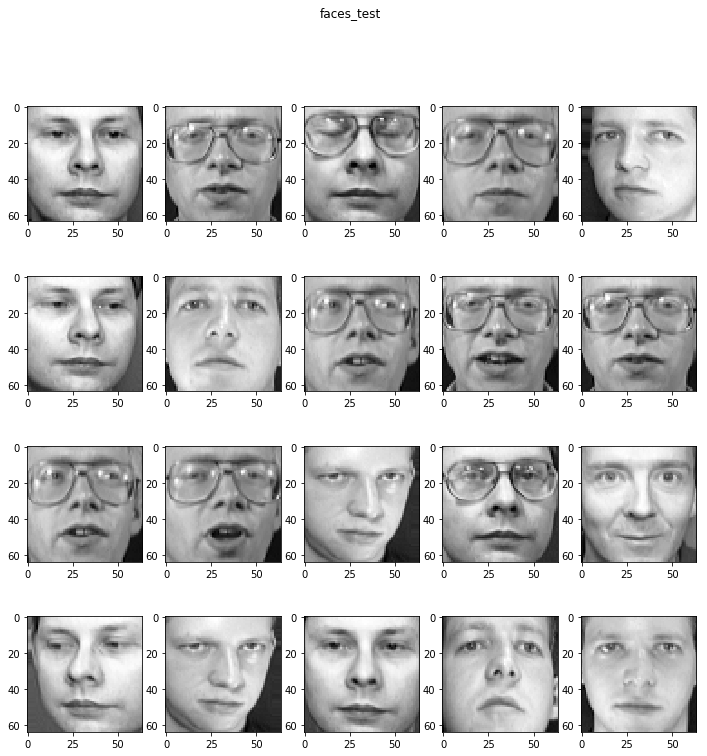

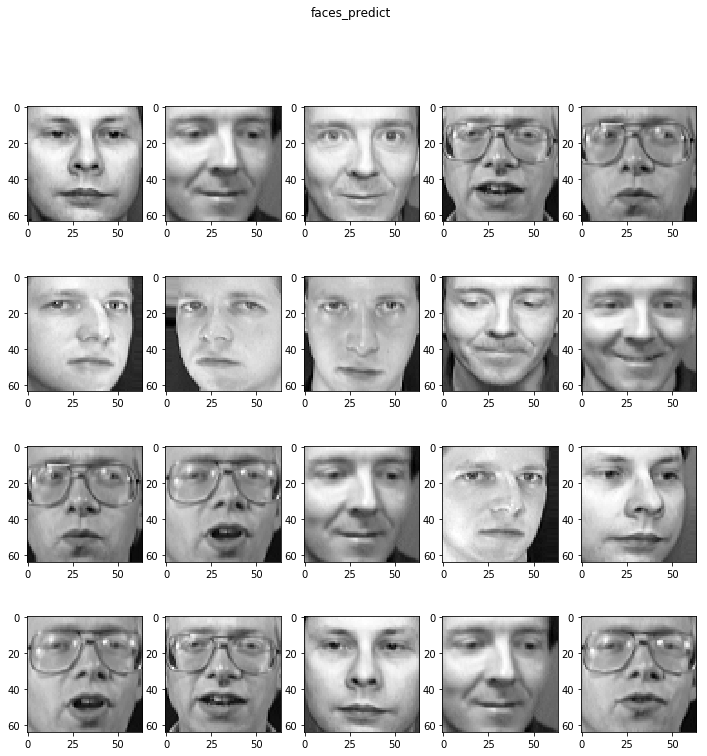

In [662]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_5 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_5)

<font color = 'red'> __Part 2: 'number of component' == 10: 0.7__</font>

In [663]:
# compute on remaining test data
pipe_pred_test_10 = pipeline_RF_10.predict(X_test)
pipe_pred_prop_10 = pipeline_RF_10.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_10))

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       1.00      1.00      1.00         3
           2       1.00      0.17      0.29         6
           3       0.11      0.33      0.17         3
           4       0.33      1.00      0.50         1
           5       0.75      0.75      0.75         4
           6       0.50      0.33      0.40         3
           7       0.33      1.00      0.50         1
           8       0.25      0.25      0.25         4
           9       1.00      0.25      0.40         4
          10       1.00      1.00      1.00         2
          11       1.00      0.40      0.57         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         0
          15       0.50      0.67      0.57         3
          16       1.00      0.50      0.67         4
          17       0.50    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 5.2 Get the wrong prediction based on this model:

In [664]:
wrong_detected(pipe_pred_test_10, 10, 120)

Wrongly detected image-locations: [0, 1, 3, 4, 6, 7, 8, 9, 10, 12, 14, 16, 18, 19, 21, 22, 23, 25, 29, 30, 31, 32, 33, 34, 36, 40, 42, 44, 45, 55, 56, 57, 64, 69, 70, 71, 77, 78, 79, 81, 84, 85, 86, 88, 92, 94, 96, 99, 100, 102, 105, 109, 112, 114]
Total: 54


- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 0,1,2,3,5,6 etc.are at error.
- <font color='red'>Total wrong prediction is 67, better than PCA(5).</font>

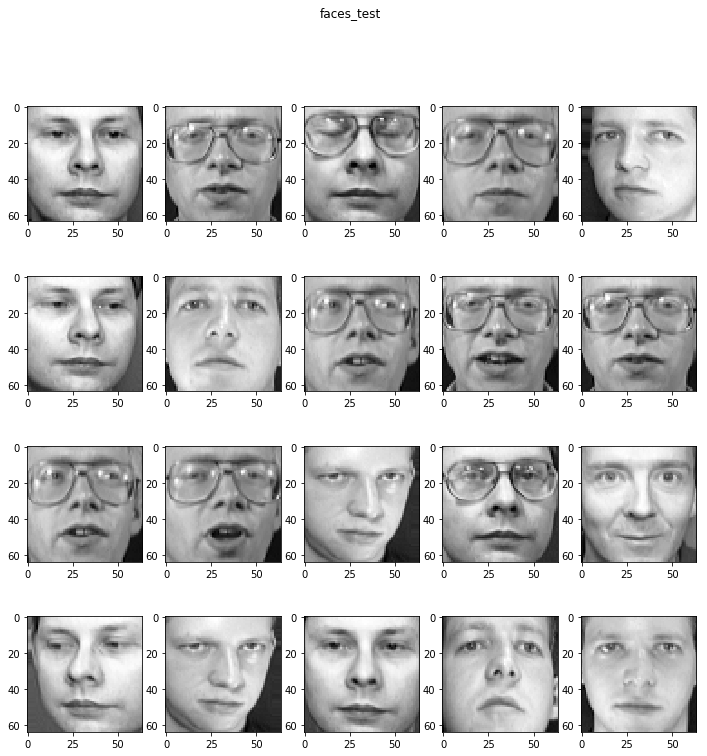

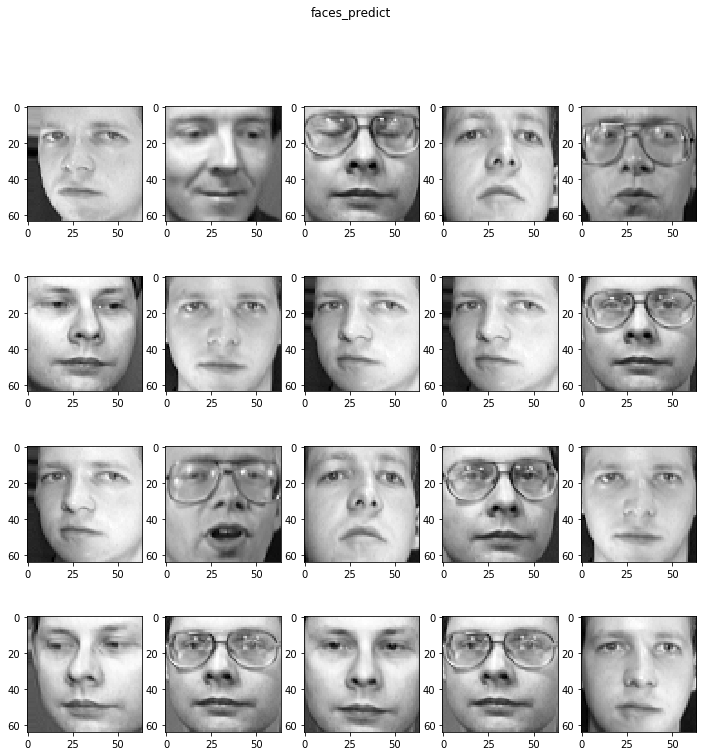

In [665]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_10 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_10)

<font color = 'red'> __Part 3: 'number of component' == 50: 0.85__</font>

#### 5.1 Predict based on pipeline, and evaluate the model:

In [666]:
pipe_pred_test_50 = pipeline_RF_50.predict(X_test)
pipe_pred_prop_50 = pipeline_RF_50.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_50))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.75      1.00      0.86         3
           2       0.50      0.17      0.25         6
           3       0.17      0.33      0.22         3
           4       0.20      1.00      0.33         1
           5       1.00      0.75      0.86         4
           6       0.14      0.33      0.20         3
           7       1.00      1.00      1.00         1
           8       0.20      0.25      0.22         4
           9       1.00      0.50      0.67         4
          10       1.00      0.50      0.67         2
          11       0.60      0.60      0.60         5
          12       0.00      0.00      0.00         1
          13       1.00      0.75      0.86         4
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         3
          16       0.67      0.50      0.57         4
          17       1.00    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 5.2 Get the wrong prediction based on this model:

In [667]:
wrong_detected(pipe_pred_test_50, 50, 120)

Wrongly detected image-locations: [3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 16, 18, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 38, 39, 40, 43, 44, 49, 50, 54, 57, 59, 60, 62, 64, 66, 67, 68, 70, 75, 77, 78, 84, 85, 86, 88, 90, 92, 93, 94, 95, 97, 98, 99, 105, 108, 109, 110, 111, 115, 117, 119]
Total: 62


- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 1,2,5,6,8 etc.are at error.
- <font color='red'>Total wrong prediction is 64, better than PCA(10).</font>

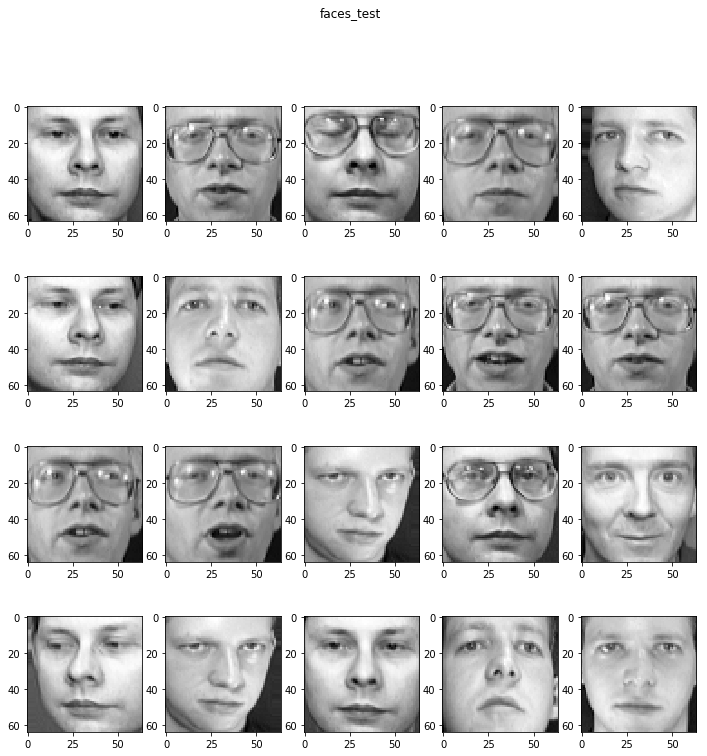

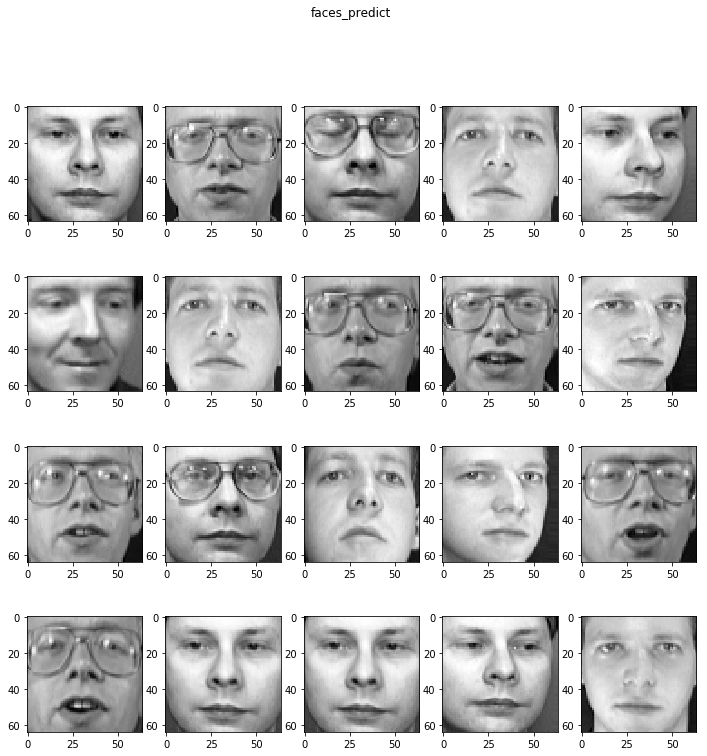

In [668]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_50 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_50)

<font color = 'red'> __Part 4: 'number of component' == 100: 0.90__</font>

#### 5.1 Predict based on pipeline, and evaluate the model:

In [669]:
pipe_pred_test_100 = pipeline_RF_100.predict(X_test)
pipe_pred_prop_100 = pipeline_RF_100.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.50      1.00      0.67         1
           5       1.00      0.50      0.67         4
           6       1.00      0.33      0.50         3
           7       1.00      1.00      1.00         1
           8       0.20      0.25      0.22         4
           9       0.60      0.75      0.67         4
          10       1.00      0.50      0.67         2
          11       0.50      0.40      0.44         5
          12       0.00      0.00      0.00         1
          13       0.75      0.75      0.75         4
          14       0.00      0.00      0.00         0
          15       0.07      0.33      0.12         3
          16       1.00      0.50      0.67         4
          17       0.40    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 5.2 Get the wrong prediction based on this model:

In [670]:
wrong_detected(pipe_pred_test_100, 100, 120)

Wrongly detected image-locations: [2, 3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 17, 18, 21, 22, 25, 27, 29, 30, 31, 32, 33, 34, 36, 39, 40, 43, 44, 49, 50, 52, 57, 59, 60, 62, 64, 66, 67, 68, 70, 71, 75, 77, 78, 79, 80, 81, 84, 85, 86, 88, 90, 92, 93, 94, 97, 98, 99, 104, 105, 106, 108, 109, 110, 111, 116, 118, 119]
Total: 68


- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 1,2,3,5,6,7 etc.are at error.
- <font color='red'>Total wrong prediction is 68, similar to PCA(50).</font>

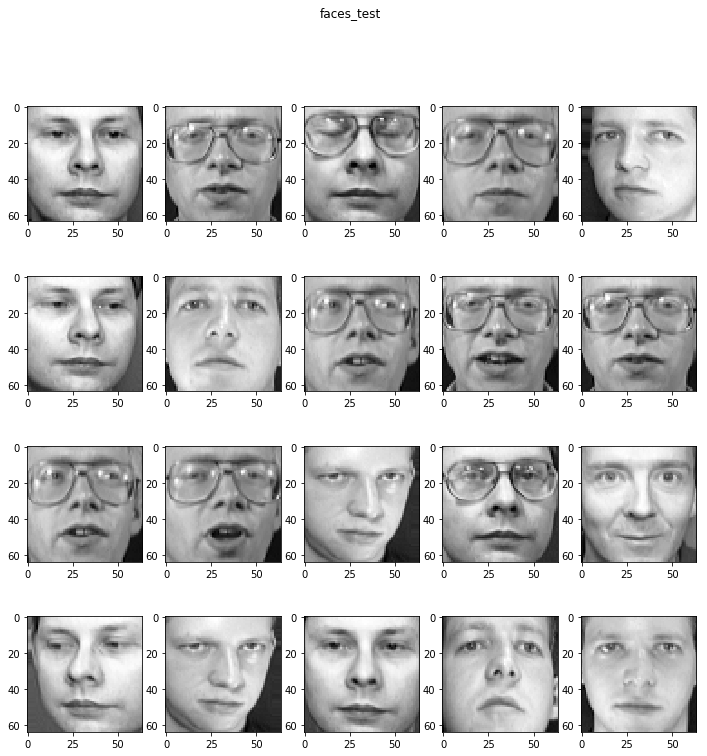

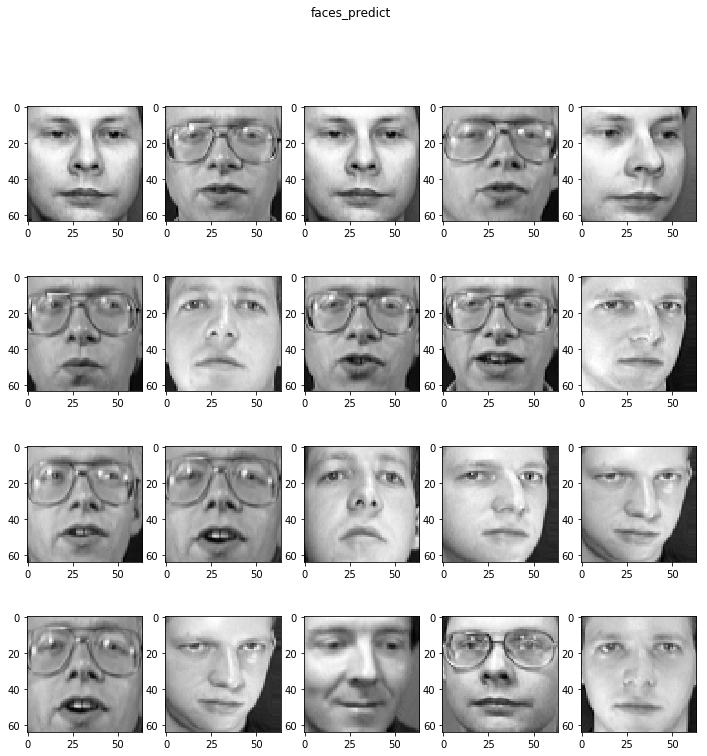

In [671]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_100 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_100)

<font color = 'red'> __Part 5: 'number of component' == 250: 0.95__</font>

#### 5.1 Predict based on pipeline, and evaluate the model:

In [672]:
pipe_pred_test_250 = pipeline_RF_250.predict(X_test)
pipe_pred_prop_250 = pipeline_RF_250.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_250))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.33      0.40         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.33      1.00      0.50         1
           5       0.00      0.00      0.00         4
           6       0.33      0.33      0.33         3
           7       0.20      1.00      0.33         1
           8       0.00      0.00      0.00         4
           9       0.33      0.25      0.29         4
          10       1.00      0.50      0.67         2
          11       0.67      0.40      0.50         5
          12       0.00      0.00      0.00         1
          13       1.00      0.75      0.86         4
          14       0.00      0.00      0.00         0
          15       0.50      0.33      0.40         3
          16       0.50      0.25      0.33         4
          17       0.67    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 5.2 Get the wrong prediction based on this model:

In [673]:
wrong_detected(pipe_pred_test_250, 250, 120)

Wrongly detected image-locations: [1, 3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 18, 19, 20, 21, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 43, 44, 46, 47, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 62, 64, 66, 67, 68, 70, 71, 72, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 97, 98, 99, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 118, 119]
Total: 83


- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 0, 2, 3, 5, 6, 8, 9 etc.are at error.
- <font color='red'>Total wrong prediction is 83.</font>

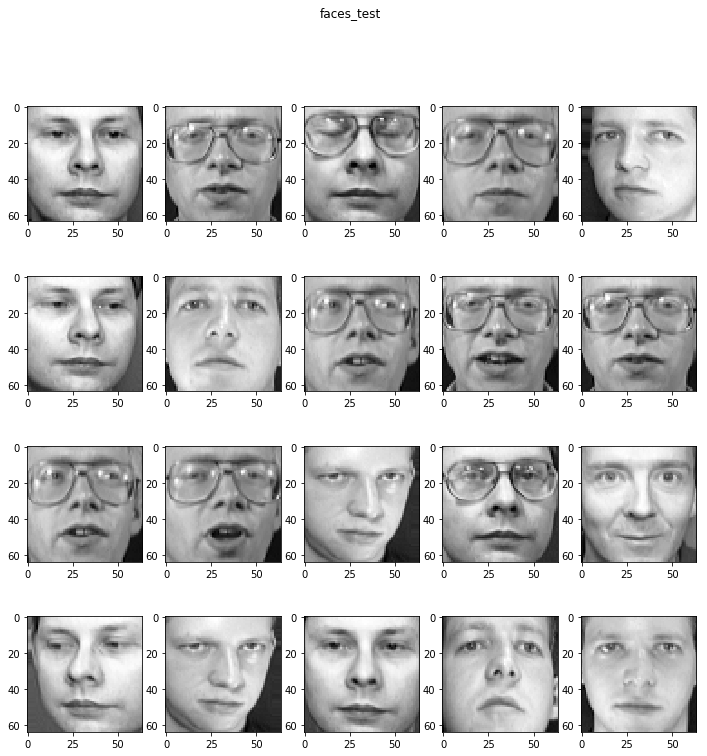

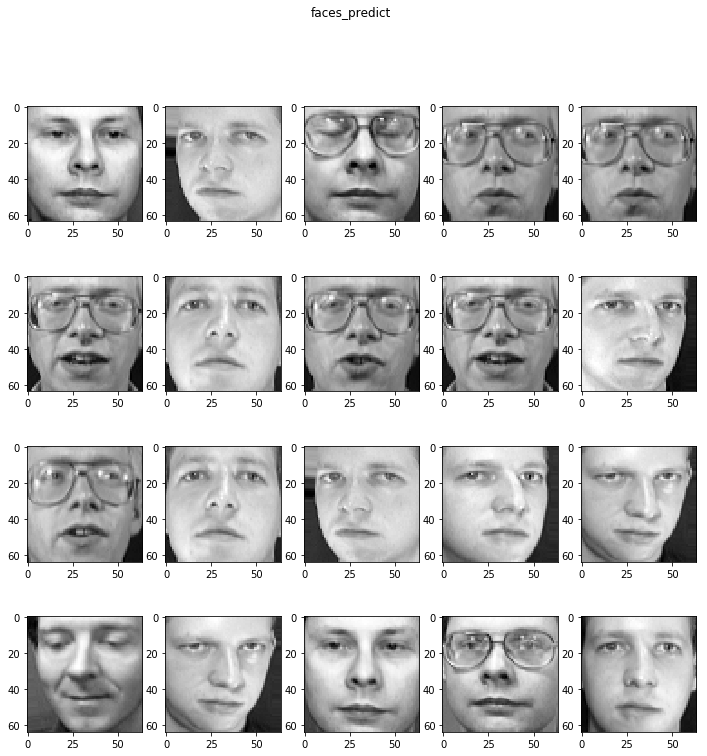

In [674]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_250 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_250)

<font color = 'red'> __Part 6: 'number of component' == 280: 0.99__</font>  

#### 5.1 Predict based on pipeline, and evaluate the model:

In [675]:
pipe_pred_test_280 = pipeline_RF_280.predict(X_test)
pipe_pred_prop_280 = pipeline_RF_280.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred = pipe_pred_test_280))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.67      0.80         3
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.50      0.25      0.33         4
           6       1.00      0.33      0.50         3
           7       0.20      1.00      0.33         1
           8       0.00      0.00      0.00         4
           9       0.50      0.25      0.33         4
          10       1.00      0.50      0.67         2
          11       1.00      0.40      0.57         5
          12       0.00      0.00      0.00         1
          13       1.00      0.75      0.86         4
          14       0.00      0.00      0.00         0
          15       0.50      0.33      0.40         3
          16       0.50      0.25      0.33         4
          17       0.33    

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 5.2 Get the wrong prediction based on this model:

In [676]:
wrong_detected(pipe_pred_test_280, 280, 120)

Wrongly detected image-locations: [3, 4, 5, 7, 9, 11, 12, 13, 14, 15, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 41, 43, 44, 46, 47, 49, 50, 51, 52, 54, 56, 57, 59, 60, 62, 64, 66, 67, 68, 70, 71, 72, 75, 76, 77, 78, 79, 80, 81, 84, 85, 86, 88, 89, 90, 92, 93, 94, 95, 97, 98, 99, 104, 106, 107, 108, 109, 110, 111, 113, 114, 117, 118, 119]
Total: 81


- The parts of plotted test-images and predicted-images are shown in figures respectively,   
- e.g.: where we can see that the image at location 0, 2, 5, 6, 8, 9, 10, 12, 14, 17 etc.are at error.
- <font color='red'>Total wrong prediction is 81.</font>

#### Check the prediction and original images by location.

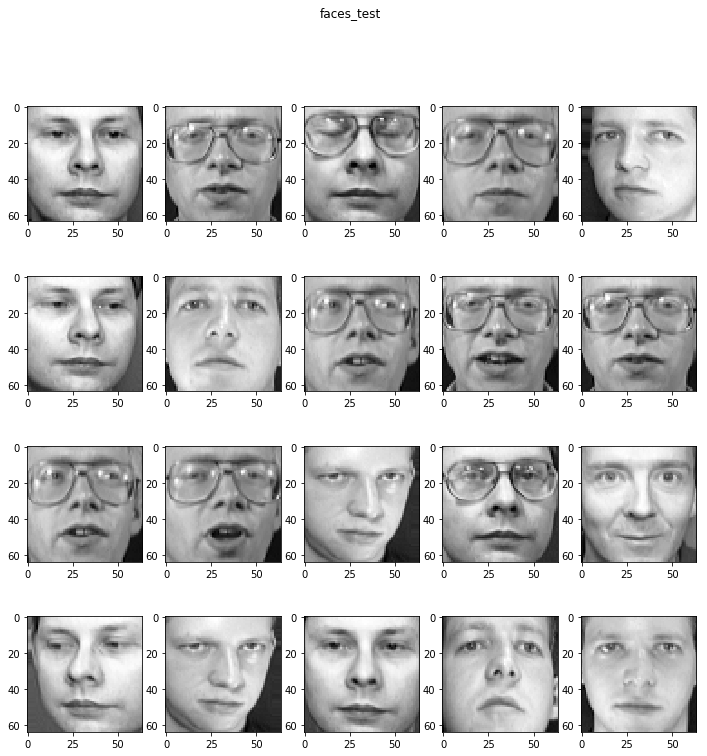

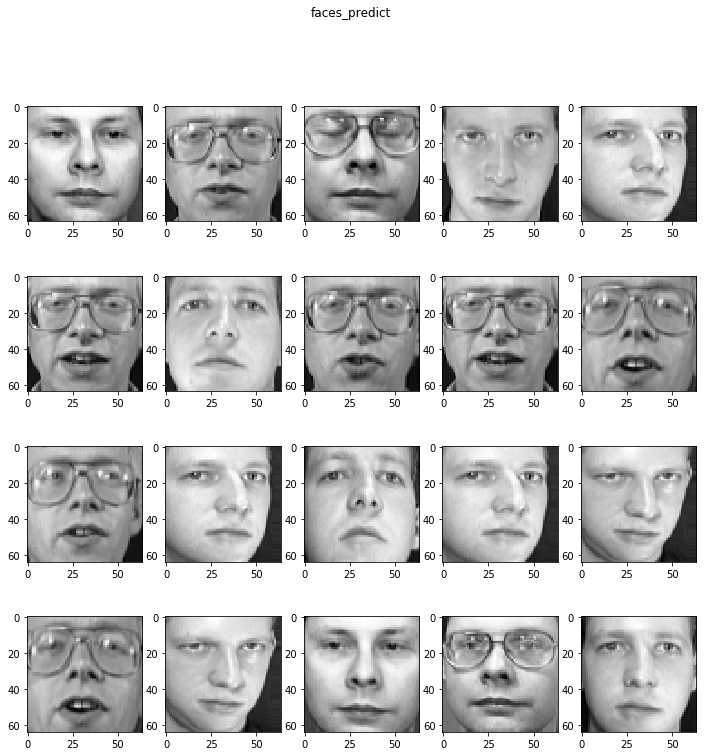

In [677]:
#compare_test_predicted(faces.images, y_test,pipe_pred_test_5)
faces_test_280 = compare_test_predicted(faces.images, 20, 4, y_test, pipe_pred_test_280)

In [678]:
list_pca_wrong_prediction_count

[(5, 69), (10, 54), (50, 62), (100, 68), (250, 83), (280, 81)]

In [679]:
li_x_PCAcomponents = [component for (component, num_wrong_predictions) in list_pca_wrong_prediction_count]
li_x_PCAcomponents

[5, 10, 50, 100, 250, 280]

In [680]:
li_y_num_correct_predictions = [(len(X_test)-num_wrong_predictions) for (component, num_wrong_predictions) in list_pca_wrong_prediction_count]
print(li_y_num_wrong_predictions)

[42, 55, 47, 39, 32, 32]


- Make a list to store (PCA_component_numbers, number of correct prediction)

In [861]:
list_pca_correct_prediction_count = list(zip(li_x_PCAcomponents, li_y_num_correct_predictions))
list_pca_correct_prediction_count

[(5, 51), (10, 66), (50, 58), (100, 52), (250, 37), (280, 39)]

__5.3 Determine the optimum number of PCA components for accuracy-wall time trade-off:__ 
- The following chart will represent the relationship between 'number of components' and 'number of correct prediction'.

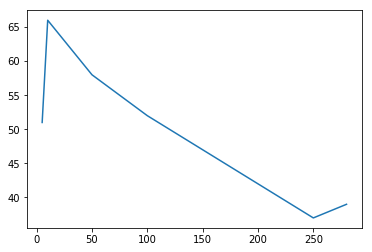

In [862]:
plt.plot(li_x_PCAcomponents, li_y_num_correct_predictions)

- Find the PCA benchmark with highest accuracy:

In [683]:
benchmark_id = max(list_pca_correct_prediction_count, key=lambda x:x[1])[0]
print('The best accuracy of PCA is with the number of component: ', benchmark_id)

The best accuracy of PCA is with the number of component:  10


#### 5.4 Reconstruct the image with the optimum PCA.  
- In order to double check if this optimum PCA number could reconstruct the image clearly, we could inverse some image.  
- We would recover most of the essential characteristics of the data by this optimum components. To make this more concrete, we can compare the input images with the images reconstructed from these optimum components

In [902]:
def inverse_reconstruction_image(imageSet, person_id, dimensions_num, reshape_x, reshape_x_projected):
# Plot the results

    pca = PCA(dimensions_num).fit(imageSet)
    print('The number of PCA components is: ', dimensions_num)
    components = pca.transform(imageSet)
    projected = pca.inverse_transform(components)

    fig, ax = plt.subplots(2, 10, figsize=(10, 3),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i in range(10):
        ax[0, i].imshow(imageSet[i+10*(int(person_id)-1)].reshape(reshape_x, -1), cmap='binary_r')
        ax[1, i].imshow(projected[i+10*(int(person_id)-1)].reshape(reshape_x, -1), cmap='binary_r')
    
    ax[0, 0].set_ylabel('full-dim\ninput')
    ax[1, 0].set_ylabel(str(dimensions_num) +'-dim\nreconstruction');

The number of PCA components is:  10


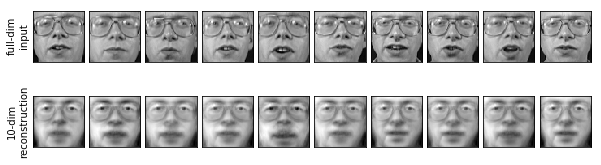

In [903]:
inverse_reconstruction_image(faces.data, 2, 10, 64, 64)

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 10 of the ~4096 initial features. This visualization makes clear why the PCA feature selection used in In-Depth: Support Vector Machines was so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image. What this means is that our classification algorithm needs to be trained on 10-dimensional data rather than 4096-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

### Conclustion:
<font color='red' >When PCA components=10, the accuracy is the peak. Thus, we could choose PCA(10) for model.</font>
- It is not always correct that the accuracy will go up along with the increasing PCA components.

### 6 Interpret the wrong prediction in non-benchmark model:

- Since we got the PCA component=10 is the best trade-off for accuracy & wall time,  <font color='red'>the model(Part 2: 'number of component' == 10) as below will be the benchmark for interpretation. </font>
  - pipeline_RF_10 = Pipeline([('Turn Gray',step_turnGray),('Flatten images', step_flatten),('Normalize', Normalizer()),
  ('PCA', PCA(10)), # # project from 4096 to 10 dimensions
  ('XGBoost_Model', GradientBoostingClassifier())])

#### 6.1 Check the overlapping wrong predictions by other non-benchmark models.

In [693]:
def getIntersectionOfWrongPredictions_non_benchmark(list_pca_number_wrongPredictionLocation):
    list_temp = [item[1] for item in list_pca_number_wrongPredictionLocation if item[0]!=benchmark_id]
    list_pca_wrongPrediction_intersection = set(list_temp[0]).intersection(*list_temp)
    
    print(list_pca_wrongPrediction_intersection, end=' ')
    return list_pca_wrongPrediction_intersection

In [695]:
list_pca_wrongPrediction_intersection = getIntersectionOfWrongPredictions_non_benchmark(list_pca_number_wrongPredictionLocation)


{3, 4, 5, 7, 9, 12, 13, 14, 15, 18, 21, 27, 32, 33, 34, 44, 49, 59, 64, 70, 75, 77, 84, 85, 86, 88, 92, 94, 99, 108, 110, 111, 119} 

- The images with postion of 3, 4, 5, 7, 9, 12, 13 etc. are the wrong predictions in non-benchmark models

#### 6.2 Interpret these overlapping wrong predictions with LIME:

__6.2.0 Goal__:  
   - Figure out what the important areas caused these failures by interpretability.

#### 6.2.1: Define function to plot:

__explanation.get_image_and_mask()__:
    https://lime-ml.readthedocs.io/en/latest/lime.html  
- label – label to explain  
- positive_only – if True, only take superpixels that contribute to the prediction of the label. Otherwise, use the top  
- num_features superpixels, which can be positive or negative towards the label  
- hide_rest – if True, make the non-explanation part of the return image gray  
- num_features – number of superpixels to include in explanation

In [756]:
def plotExplanationWithMask(explanation, pipeline_name, testImage, image_location, positive_num_features, posNeg_num_features, if_hide_rest):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    fig.suptitle('{}'.format(pipeline_name), fontsize=10, fontweight='bold')

    temp, mask = explanation.get_image_and_mask(testImage[image_location], positive_only=True, num_features=positive_num_features, hide_rest = if_hide_rest)
    
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(testImage[image_location]))
    
    temp, mask = explanation.get_image_and_mask(testImage[image_location], positive_only=False, num_features=posNeg_num_features, hide_rest = if_hide_rest)
    
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(testImage[image_location]))    
    
    dirName = 'Output/'+str(image_location)+'/'
    
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory: " , dirName ,  " Created ")
    else:    
        print("Directory: " , dirName ,  " already exists")
    
    save_image_path = dirName+str(image_location)+'_'+pipeline_name+'.jpg'
    plt.savefig(save_image_path)
    
    print(str(image_location)+'_'+pipeline_name+' has been saved under '+dirName)
    

In [733]:
def saveImage(fig, pipeline_name, image_location):
    save_image_path = 'Output/'+str(image_location)+'/'+str(image_location)+'_'+pipeline_name+'.jpg'
    plt.savefig(save_image_path)
    
    plt.close(fig)

In [697]:
np.array(list_pca_wrongPrediction_intersection)

array({3, 4, 5, 7, 9, 12, 13, 14, 15, 18, 21, 27, 32, 33, 34, 44, 49, 59, 64, 70, 75, 77, 84, 85, 86, 88, 92, 94, 99, 108, 110, 111, 119},
      dtype=object)

- Randomly pick one of wrong predictions from the intersection for futher interpretability: 

In [708]:
error_location = random.choice(list(list_pca_wrongPrediction_intersection))
error_location

86

#### 6.2.2 Explain the pipelines with different PCA components:

In [702]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from lime import lime_image

- __Segmentation for LIME interpretability:__  
    - __SLIC( Simple Linear Iterative Clustering)__: 
        - Uses a machine learning algorithm called K-Means(Unsupervised segmentation) under the hood.  
        - It takes in all the pixel values of the image and tries to separate them out into the given number of sub-regions. (In this case, reduced this image from 64*64 pixels/image down to 100 regions.)

In [703]:
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

#### 6.2.3 Interpret the wrong predictions generated by different PCA components and plot:  

<font color='red'>__- Don't know why the images could not be displayed by nbviewer or github__: https://nbviewer.jupyter.org/github/ziweifan177/Data_Science_Pilot/blob/master/%5BProjects%20and%20Testing%5D%20Data%20Science%20%26%20Machine%20Learning/%28Paper-Faces%20Data%29%20How_Models_and_Interpretability_Affected_by_PCA/Image_Interpretability_Affected_by_PCA%20%28Faces%20Data%29.ipynb  
    
- Actions:  
For convenient checking in case this output image could not be displayed, it has been attached here or:
    1. Please go to 'Output' folder for checking final comparison results.  
    2. Or download this file to local.
    </font>

- We will get two images:  
    - which display the areas which have contributed positively towards the prediction by red, and  
    - the features which have negatively contributed by purple

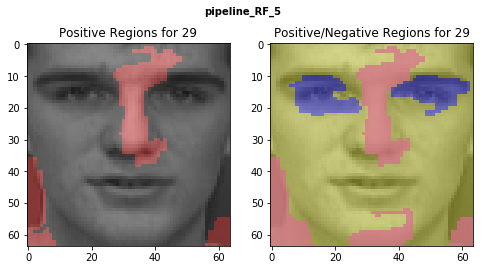

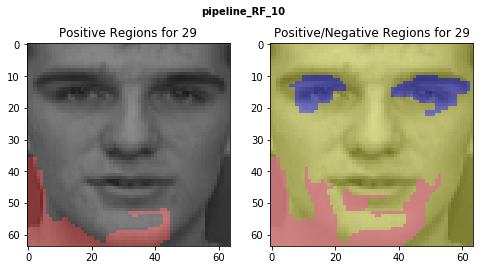

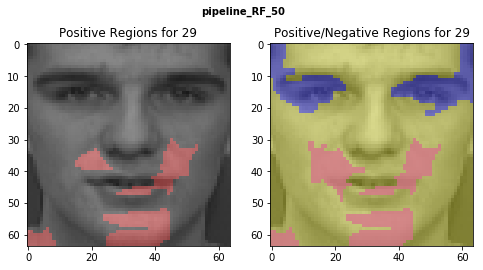

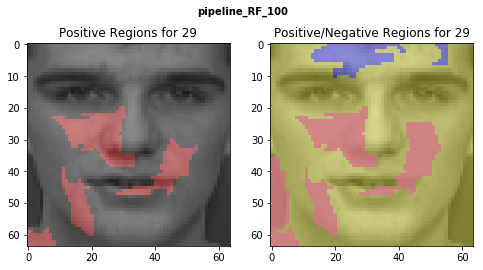

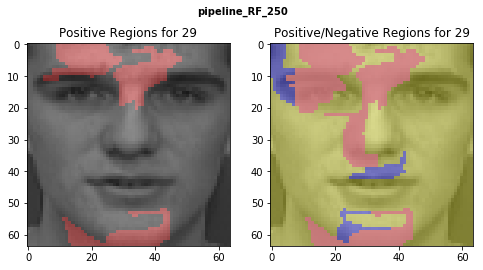

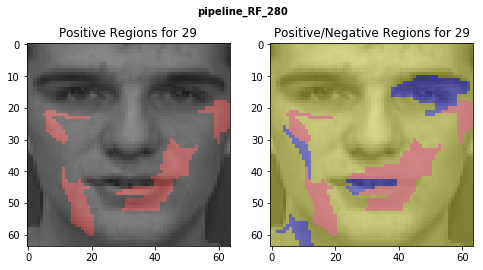

In [742]:
for (pipeline_name, pipeline) in list_pipeline_RF:
    #print(pipeline_name)
    explanation_proba = explainer.explain_instance(X_test[error_location], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=50, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    plotExplanationWithMask(explanation_proba, pipeline_name, y_test, error_location, 5, 10, False)

#### Conclusion:  
- It is found some areas are interpreted differently by comparing with PCA(10) benchmark by following chart. (Green: Same with benchmark; Red: Different)
<img src='Output/34/34_B_Compare.png'>
- Other alternative better substitute: P(5)

#### 6.2.4 Interpret another wrong prediction:  

- Randomly pick another wrong prediction from intersection of wrong prediction:

In [752]:
error_location = random.choice(list(list_pca_wrongPrediction_intersection))
error_location

44

Directory:  Output/44/  Created 
44_pipeline_RF_5 has been saved under Output/44/
Directory:  Output/44/  already exists
44_pipeline_RF_10 has been saved under Output/44/
Directory:  Output/44/  already exists
44_pipeline_RF_50 has been saved under Output/44/
Directory:  Output/44/  already exists
44_pipeline_RF_100 has been saved under Output/44/
Directory:  Output/44/  already exists
44_pipeline_RF_250 has been saved under Output/44/
Directory:  Output/44/  already exists
44_pipeline_RF_280 has been saved under Output/44/


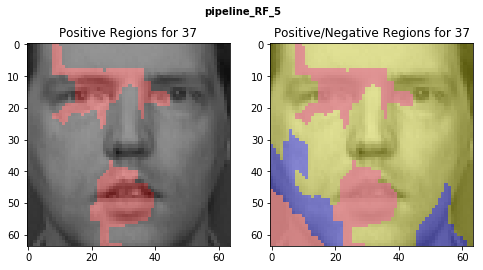

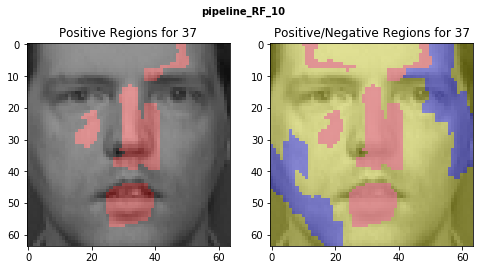

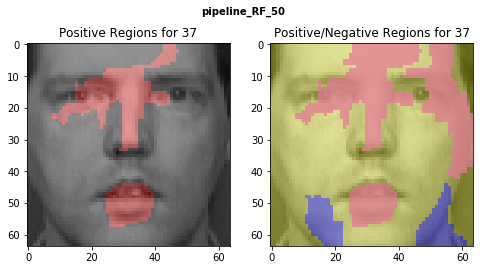

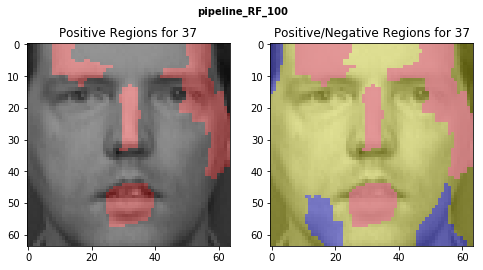

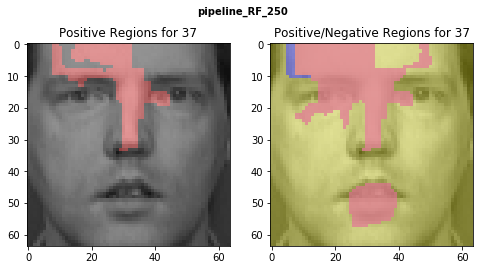

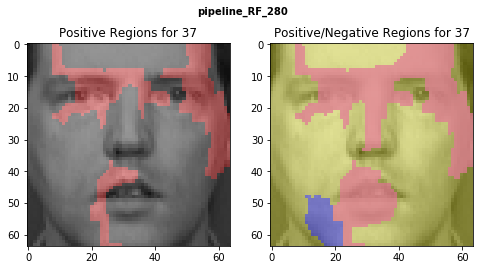

In [757]:
for (pipeline_name, pipeline) in list_pipeline_RF:
    #print(pipeline_name)
    explanation_proba = explainer.explain_instance(X_test[error_location], 
                                         classifier_fn = pipeline.predict_proba, 
                                         top_labels=50, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
    plotExplanationWithMask(explanation_proba, pipeline_name, y_test, error_location, 5, 10, False)
    
    #saveImage(fig, pipeline_name, error_location)

#### Conclusion:  
- It is found some areas are interpreted differently by comparing with PCA(10) benchmark by following chart. (Green: Same with benchmark; Red: Different)
<img src='Output/44/44_B_Compare.png'>
- Another models(PCA(100), PCA(280)) could be the substitute of benchmark model.

## Wrapping up:  
- It is not always correct that PCA works better with increasing of PCA components, and different PCA principal vectors seem to be picking out certain features differently, such as eyes, noses, and lips.
- LIME image interpretability will help to understand how the models perform differently.

## Further step:
- This work focused on SVM model, and combine with different PCA component for image classification and interpretability.
- Further I will explore how different PCA and interpretability work on the other algorithms.
- Another step, explore the optimum combination of PCA components number and model for better image reconstruction.

## Reference:  
- Image Segmentation using Python’s scikit-image module: https://towardsdatascience.com/image-segmentation-using-pythons-scikit-image-module-533a61ecc980  
- In Depth: Principal Component Analysis: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

## Appendix:

In [ ]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
img = imread('data/att_faces/s1/1.pgm')
img = img.astype(np.uint8)
img = img / 255
plt.imshow(img,cmap='gray')